In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold

import lightgbm as lgb

MAX_EVALS = 500
K = 10

In [4]:
data = pd.read_csv('caravan-insurance-challenge.csv')
train = data[data['ORIGIN'] == 'train']
test = data[data['ORIGIN'] == 'test']

print(train.shape)
print(test.shape)

(5822, 87)
(4000, 87)


In [5]:
#preprocesamiento
train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
test_labels = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))

train = train.drop(columns = ['ORIGIN', 'CARAVAN'])
test = test.drop(columns = ['ORIGIN', 'CARAVAN'])

features = np.array(train)
test_features = np.array(test)
labels = train_labels[:]

print('Train: ', train.shape)
print('Test: ', test.shape)
train.head()

Train:  (5822, 85)
Test:  (4000, 85)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


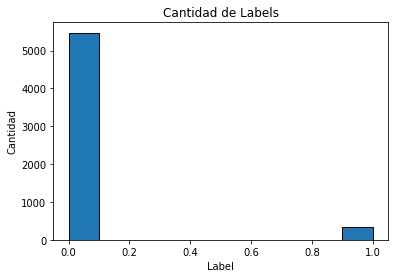

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.hist(labels, edgecolor = 'k');
plt.xlabel('Label');
plt.ylabel('Cantidad');
plt.title('Cantidad de Labels');

###Resultados Base (sin optimización)

In [7]:
model = lgb.LGBMClassifier()
model

LGBMClassifier()

In [8]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

t_inicio = timer()
model.fit(features, labels) #X, y
t_train = timer() - t_inicio

predicciones = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predicciones) # y_reales, y_predichos

print('La métrica Base en test es {:.4f}.'.format(auc))
print('Tiempo de entrenamiento es {:.4f} segundos'.format(t_train))

La métrica Base en test es 0.7092.
Tiempo de entrenamiento es 0.3348 segundos


###Random Search

In [9]:
import random

In [10]:
#Dominio
#Espacio de búsqueda de Hyperparámetros
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt','goss','dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 500000)),
    'min_child_samples': list(range(20,500,5)),
    'reg_alpha': list(np.linspace(0,1)),
    'reg_lambda': list(np.linspace(0,1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

subsample_dist = list(np.linspace(0.5,1,100)) #se va a utilizar en el caso de 'boosting_type'='goss'

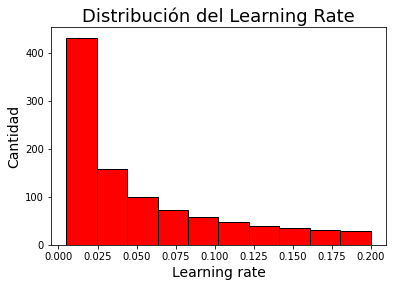

In [11]:
plt.hist(param_grid['learning_rate'], color='r', edgecolor='k');
plt.xlabel('Learning rate', size= 14);
plt.ylabel('Cantidad', size=14);
plt.title('Distribución del Learning Rate', size= 18);

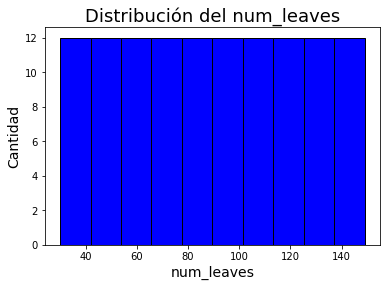

In [12]:
plt.hist(param_grid['num_leaves'], color='b', edgecolor='k');
plt.xlabel('num_leaves', size= 14);
plt.ylabel('Cantidad', size=14);
plt.title('Distribución del num_leaves', size= 18);

In [13]:
#Tomar una muestra del dominio de hiperparámetros
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'class_weight': 'balanced',
 'boosting_type': 'goss',
 'num_leaves': 96,
 'learning_rate': 0.01235570696588628,
 'subsample_for_bin': 20000,
 'min_child_samples': 265,
 'reg_alpha': 0.7142857142857142,
 'reg_lambda': 0.2040816326530612,
 'colsample_bytree': 0.8222222222222222}

In [14]:
params['subsample'] = random.sample(subsample_dist, 1)[0] if params['boosting_type'] != 'goss' else 1.0
params

{'class_weight': 'balanced',
 'boosting_type': 'goss',
 'num_leaves': 96,
 'learning_rate': 0.01235570696588628,
 'subsample_for_bin': 20000,
 'min_child_samples': 265,
 'reg_alpha': 0.7142857142857142,
 'reg_lambda': 0.2040816326530612,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 1.0}

In [15]:
#Validación cruzada con interrupción temprana en LightGBM

train_set = lgb.Dataset(features, label = labels)

r = lgb.cv(params, train_set, num_boost_round=10000, nfold=10, metrics='auc', early_stopping_rounds=100, verbose_eval=False, seed=50)
r_best = np.max(r['auc-mean'])
r_best_std = r['auc-stdv'][np.argmax(r['auc-mean'])]

print('El máximo AUC:{:.5f}.'.format(r_best, r_best_std))
print('número iteraciones ideales: {}.'.format(np.argmax(r['auc-mean'])+1))

El máximo AUC:0.75741.
número iteraciones ideales: 78.


In [16]:
#dataframe para los resultados de random search
random_results = pd.DataFrame(columns = ['loss','params','iteration','estimators','time'], index = list(range(MAX_EVALS)))

In [17]:
from time import time

#Definición de la Función Objetivo
def random_objective(params, iteration, n_folds = K):
  print(iteration)
  
  t_inicio = time()
  cv_results = lgb.cv(params, train_set, num_boost_round=10000, nfold=n_folds, metrics='auc', early_stopping_rounds=100, seed=50)
  t_total = time() - t_inicio

  best_score = np.max(cv_results['auc-mean'])
  loss = 1 - best_score #Los algoritmos de busqueda, generalmente Minimizan.

  n_estimators = int(np.argmax(cv_results['auc-mean'])+1)

  return [loss, params, iteration, n_estimators, t_total]

In [ ]:

#implementación de Random Search

%%capture
random.seed(50)

for i in range(MAX_EVALS):

  params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()} #El paso de valor aleatorio de random Search
  print(params)

  if params['boosting_type'] == 'goss':
    params['subsample'] = 1.0
  else:
    params['subsample'] = random.sample(subsample_dist, 1)[0]
  

  results_list = random_objective(params, i)
  random_results.loc[i,:] = results_list

In [ ]:
#Reordenamiento
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace= True, drop=True)
random_results.head()

In [ ]:
#El mejor tuning de hiperparámetros
random_results.loc[0, 'params']

In [ ]:
#Para utilizar el mejor tuning en el modelo
best_random_params = random_results.loc[0, 'params'].copy()
best_random_estimators = int(random_results.loc[0,'estimators'])

#TUNEAR EL MODELO
best_random_model = lgb.LGBClassifier(n_estimators = best_random_estimators, n_jobs = -1, objective='binary', **best_random_params, random_state = 50)
best_random_model.fit(features, labels)

predicciones = best_random_model.predict_proba(test_features)[:, 1]

print('El máximo AUC:{:.5f}.'.format(roc_auc_score(test_labels, predicciones)))
print('número iteraciones ideales: {}.'.format(random_results.loc[0,'iteration']))